C:\Users\tavim\AppData\Local\Temp\ipykernel_27568\3272603435.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)


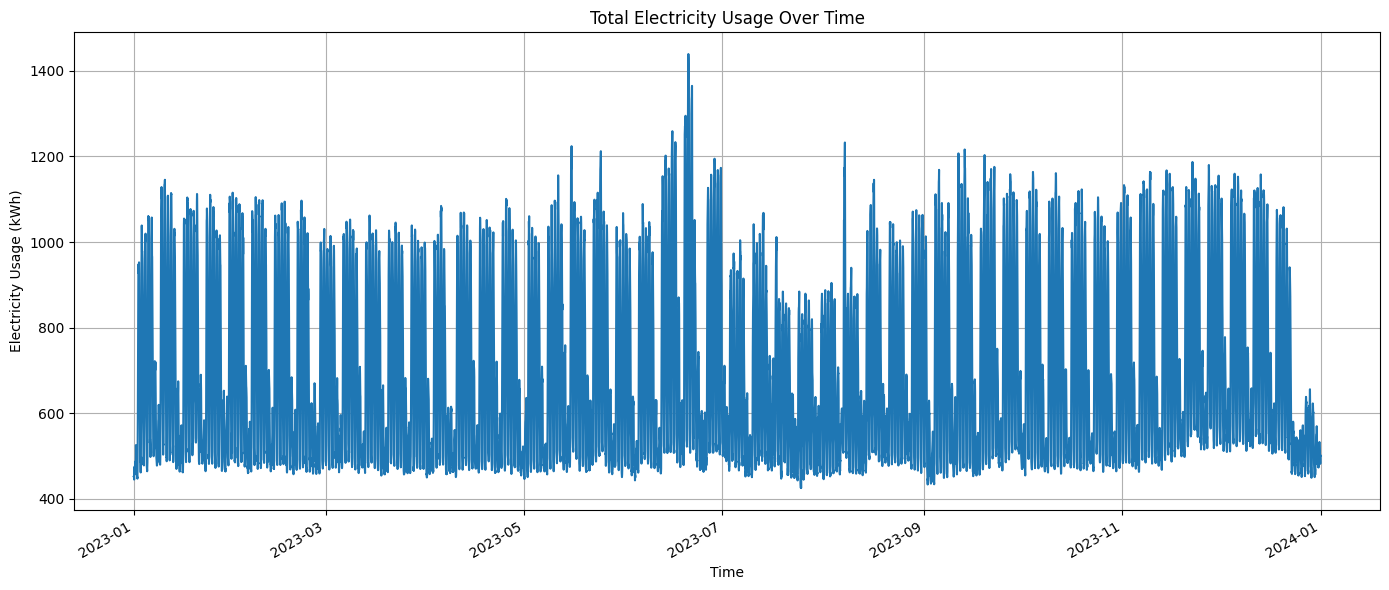

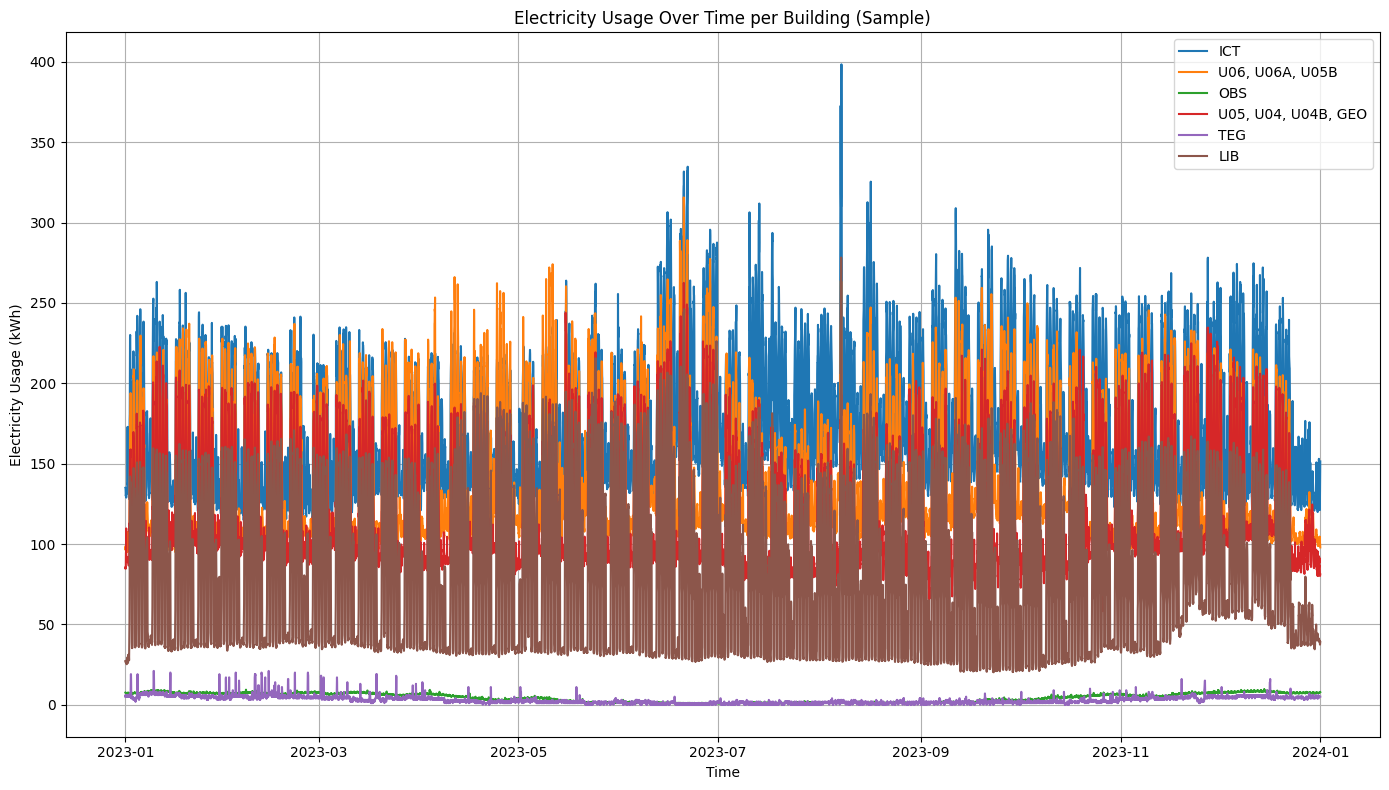

<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
xls = pd.ExcelFile("Buildings_el.xlsx")
electricity_df = xls.parse('Electricity kWh')
weather_df = xls.parse('Weather archive')

# Clean electricity data
new_header = electricity_df.iloc[0]
electricity_df_clean = electricity_df[1:].copy()
electricity_df_clean.columns = new_header
electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)
electricity_df_clean["Timestamp"] = pd.to_datetime(electricity_df_clean["Timestamp"])
electricity_df_clean.set_index("Timestamp", inplace=True)
electricity_df_clean = electricity_df_clean.apply(pd.to_numeric, errors='coerce')

# Reshape to long format
electricity_long = electricity_df_clean.reset_index().melt(id_vars="Timestamp", 
                                                           var_name="Building", 
                                                           value_name="kWh")
electricity_long.dropna(inplace=True)

# --- PLOT 1: Total Electricity Usage Over Time ---
plt.figure(figsize=(14, 6))
total_usage = electricity_df_clean.sum(axis=1)
total_usage.plot()
plt.title("Total Electricity Usage Over Time")
plt.ylabel("Electricity Usage (kWh)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 2: Electricity Usage Over Time per Building (Sample of 6) ---
sample_buildings = electricity_long['Building'].unique()[:6]
plt.figure(figsize=(14, 8))
for building in sample_buildings:
    subset = electricity_long[electricity_long['Building'] == building]
    plt.plot(subset['Timestamp'], subset['kWh'], label=building)

plt.title("Electricity Usage Over Time per Building (Sample)")
plt.ylabel("Electricity Usage (kWh)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# --- PLOT 3: Distribution of Electricity Usage (Histogram + KDE) ---
plt.figure


C:\Users\tavim\AppData\Local\Temp\ipykernel_5568\2650643753.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)
C:\Users\tavim\AppData\Local\Temp\ipykernel_5568\2650643753.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df_clean = weather_df_clean.set_index("Timestamp").resample("H").mean()


Index(['Timestamp', 'T', 'P0', 'P', 'U', 'DD', 'Ff', 'ff10', 'WW', 'W'W'', 'c',
       'VV', 'Td'],
      dtype='object', name=1)


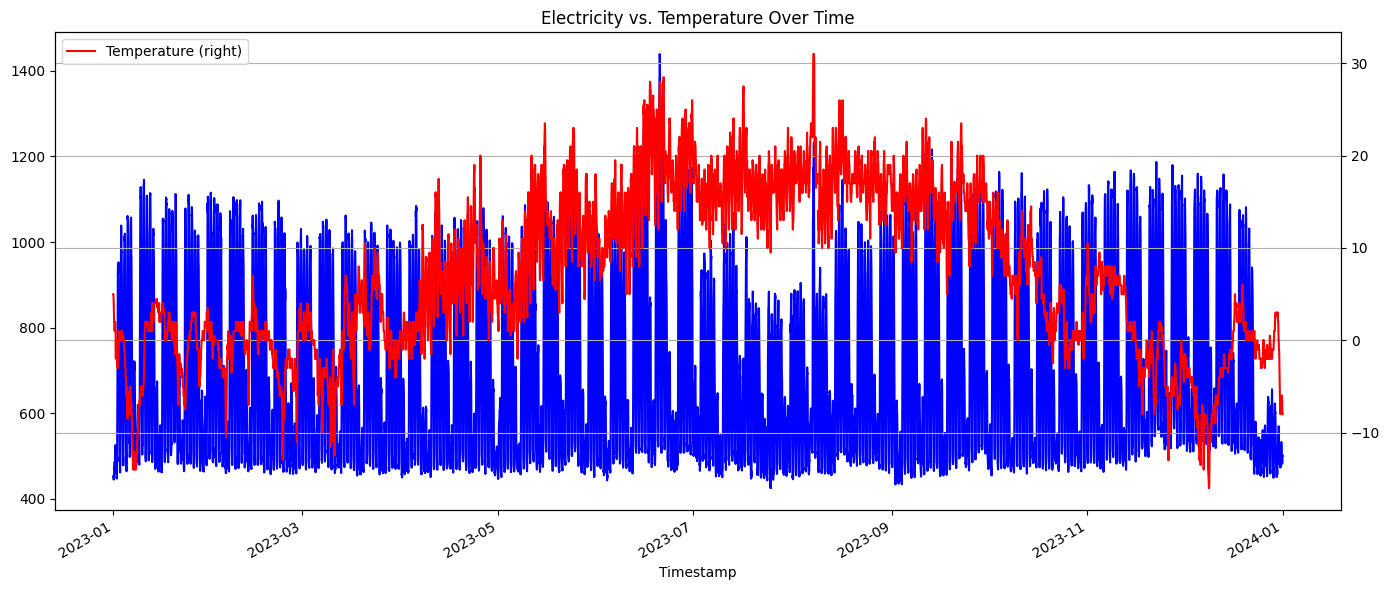

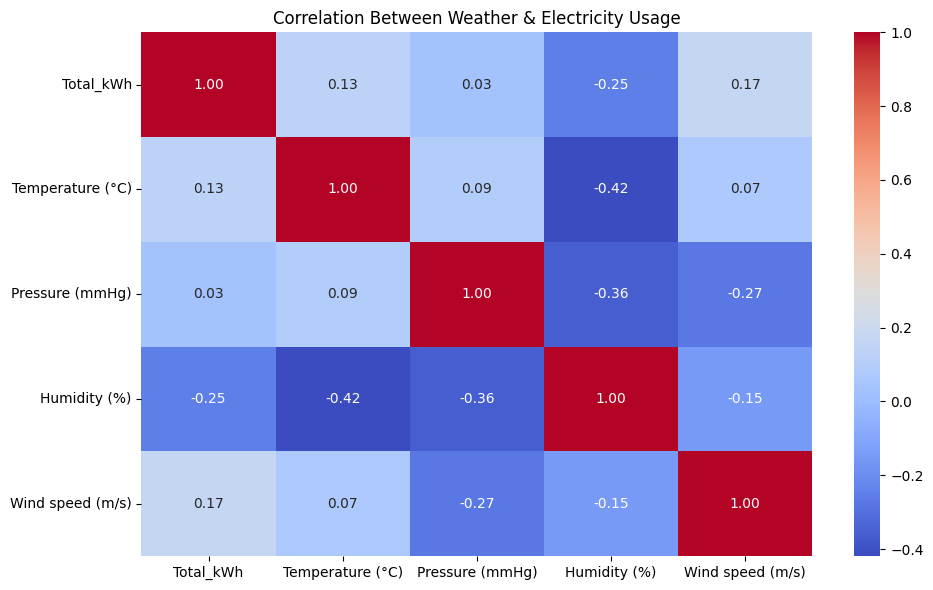

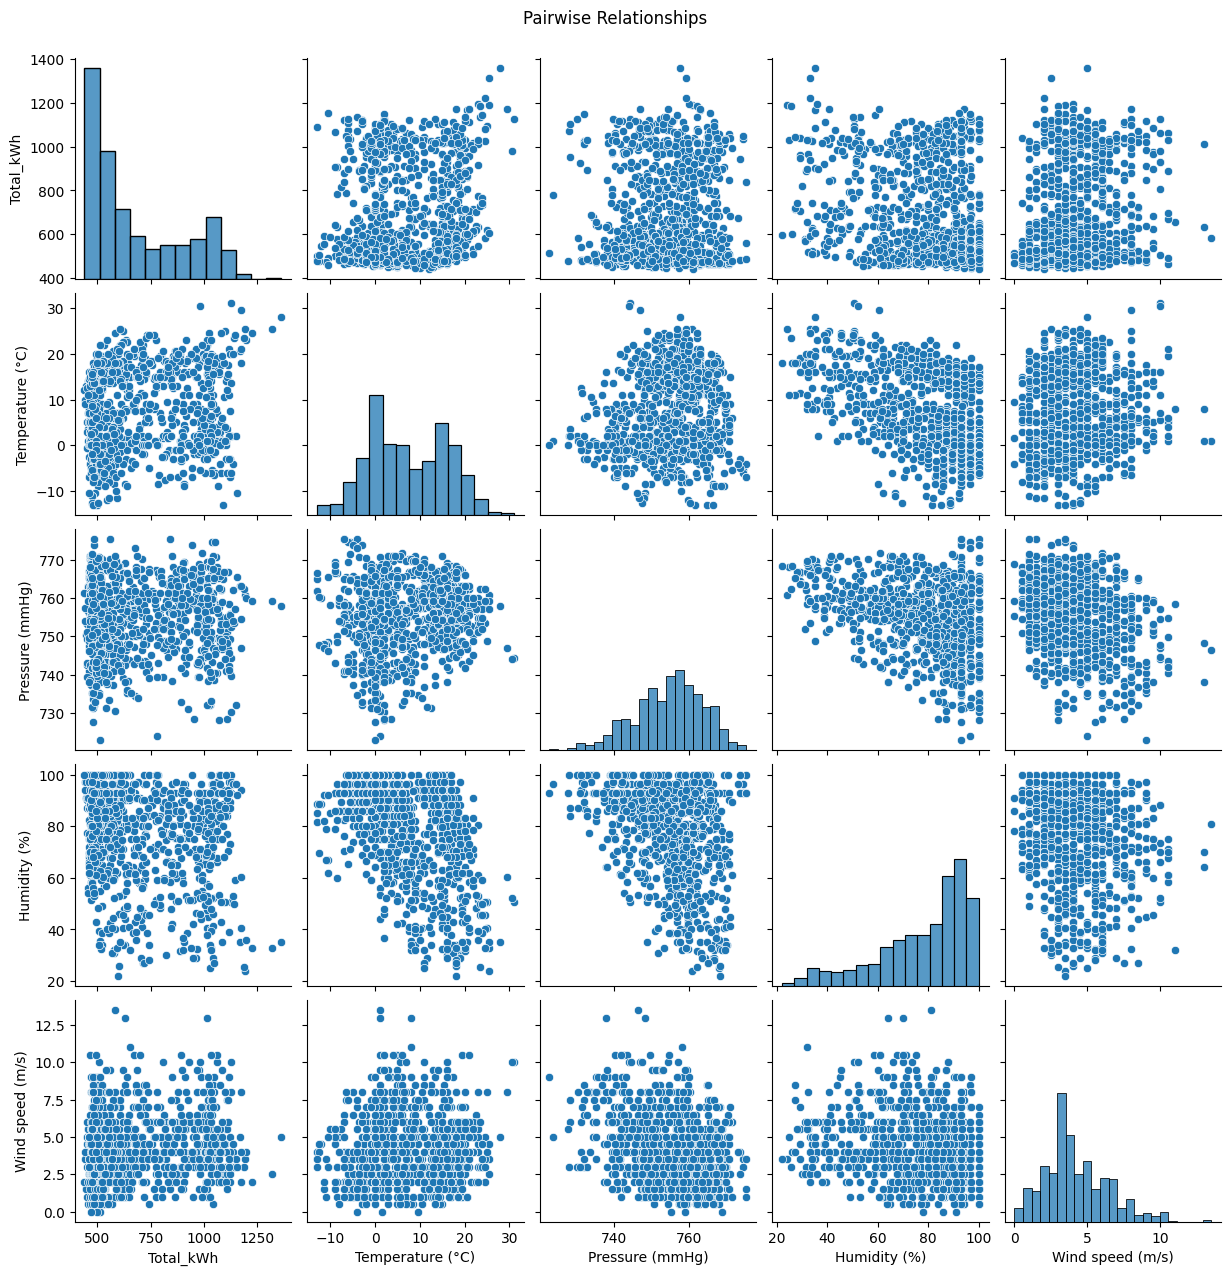

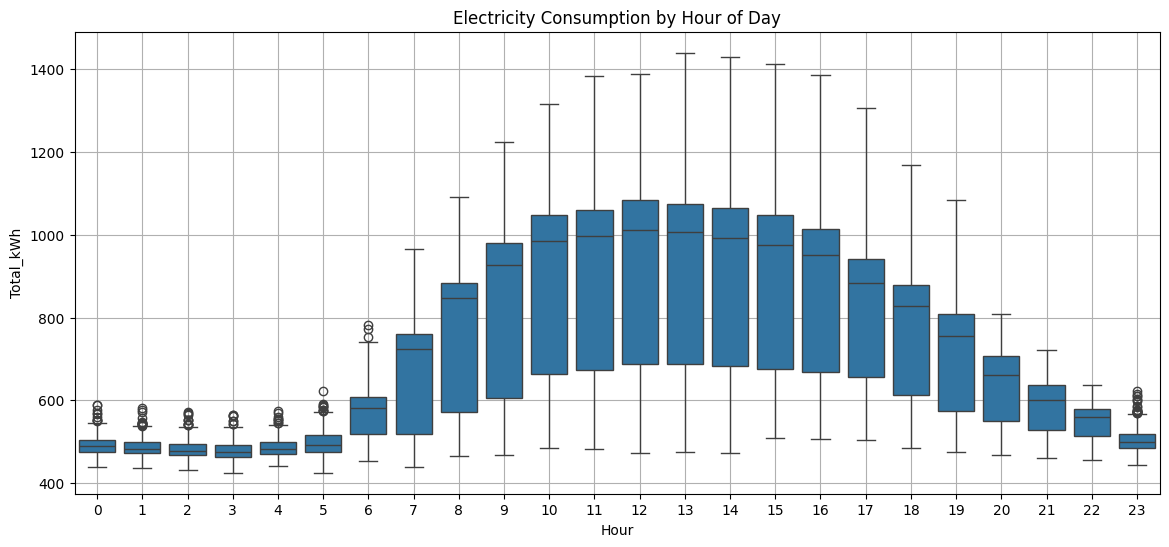

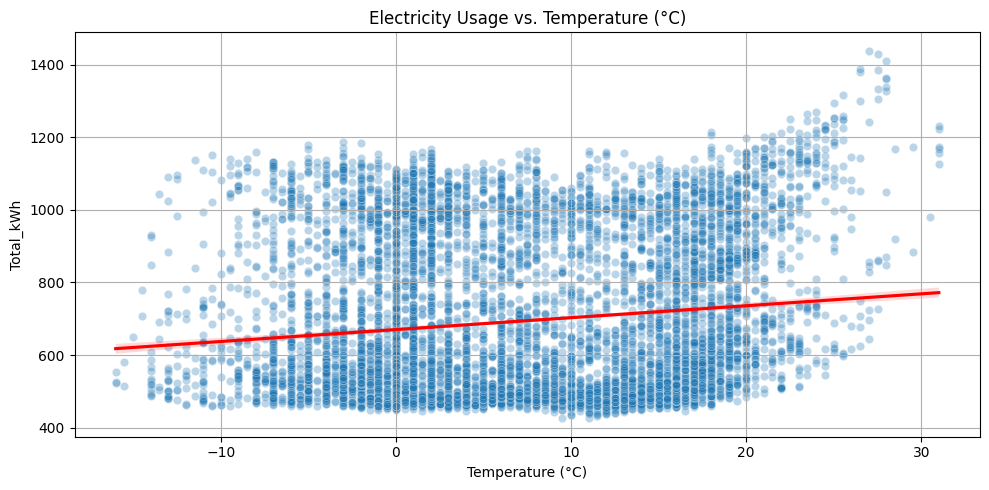

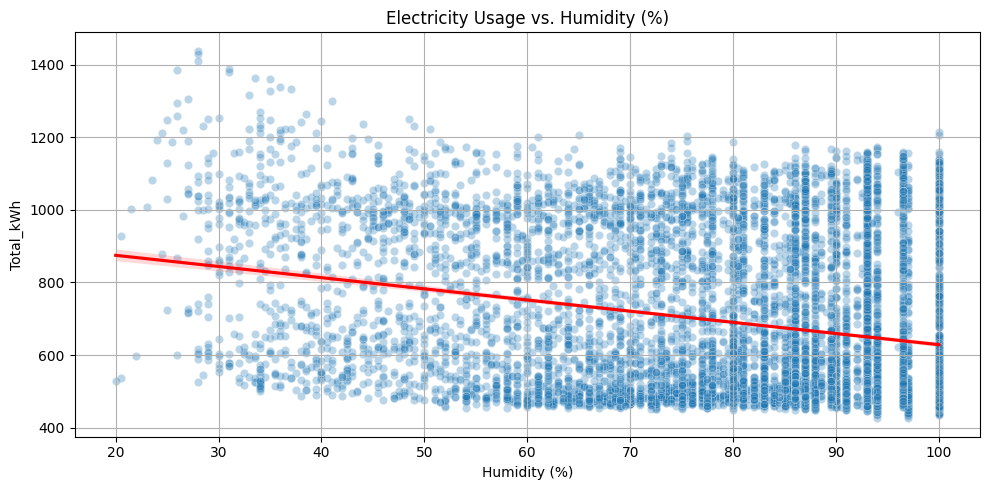

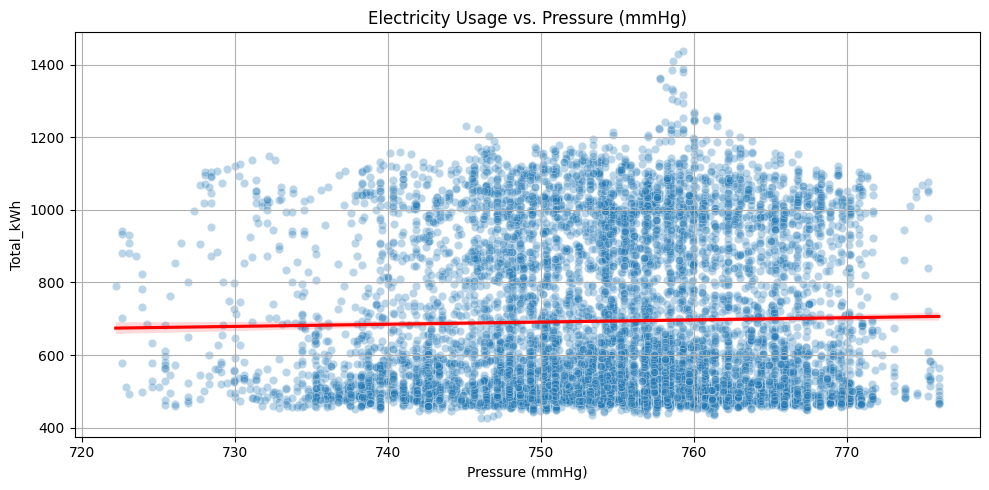

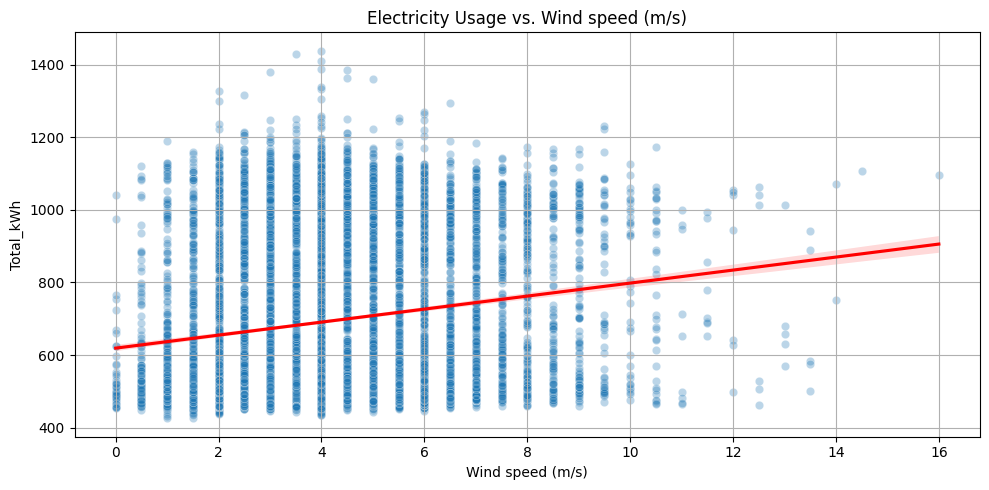

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the Excel file
xls = pd.ExcelFile("Buildings_el.xlsx")
electricity_df = xls.parse('Electricity kWh')
weather_df = xls.parse('Weather archive')

# -------- CLEAN ELECTRICITY DATA --------
new_header = electricity_df.iloc[0]
electricity_df_clean = electricity_df[1:].copy()
electricity_df_clean.columns = new_header
electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)
electricity_df_clean["Timestamp"] = pd.to_datetime(electricity_df_clean["Timestamp"])
electricity_df_clean.set_index("Timestamp", inplace=True)
electricity_df_clean = electricity_df_clean.apply(pd.to_numeric, errors='coerce')

#THERE IS A DUPLICATE INDEX IN THE DATAFRAME FOR ELECTRICITY (29.10.2023 03:00:00), SO WE NEED TO AVERAGE THE VALUES FOR THAT TIME TO REMOVE THE DUPLICATE, 
duplicate_index = electricity_df_clean.index[electricity_df_clean.index.duplicated()]
electricity_df_clean = electricity_df_clean.groupby(electricity_df_clean.index).mean()


# Create total usage column
electricity_df_clean["Total_kWh"] = electricity_df_clean.sum(axis=1)

# -------- CLEAN WEATHER DATA --------
weather_df.columns = weather_df.iloc[1]
weather_df_clean = weather_df[2:].copy()
weather_df_clean = weather_df_clean.rename(columns={"Local time in Tallinn ": "Timestamp"})
print(weather_df_clean.columns)
weather_df_clean["Timestamp"] = pd.to_datetime(weather_df_clean["Timestamp"], dayfirst=True, errors='coerce')

# Rename relevant columns for clarity
weather_df_clean = weather_df_clean.rename(columns={
    "T": "Temperature (°C)",
    "P0": "Pressure (mmHg)",
    "U": "Humidity (%)",
    "Ff": "Wind speed (m/s)"
})

# Convert numeric fields
numeric_cols = ["Temperature (°C)", "Pressure (mmHg)", "Humidity (%)", "Wind speed (m/s)"]
for col in numeric_cols:
    weather_df_clean[col] = pd.to_numeric(weather_df_clean[col], errors='coerce')

weather_df_clean = weather_df_clean[["Timestamp"] + numeric_cols].dropna()
weather_df_clean = weather_df_clean.set_index("Timestamp").resample("H").mean()

# -------- MERGE WEATHER + ELECTRICITY --------
combined_df = electricity_df_clean.merge(weather_df_clean, left_index=True, right_index=True, how='inner')

# -------- EDA SECTION --------

# --- 1. Time Series Plots of Features ---
plt.figure(figsize=(14, 6))
combined_df["Total_kWh"].plot(label="Total Electricity", color='blue')
combined_df["Temperature (°C)"].plot(label="Temperature", secondary_y=True, color='red')
plt.title("Electricity vs. Temperature Over Time")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# --- 2. Correlation Heatmap ---
plt.figure(figsize=(10, 6))
corr = combined_df[["Total_kWh"] + numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Weather & Electricity Usage")
plt.tight_layout()
plt.show()

# --- 3. Pairplot of Features ---
sns.pairplot(combined_df[["Total_kWh", "Temperature (°C)", "Pressure (mmHg)", "Humidity (%)", "Wind speed (m/s)"]].sample(1000))
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

# --- 4. Boxplots by Hour of Day ---
combined_df["Hour"] = combined_df.index.hour
plt.figure(figsize=(14, 6))
sns.boxplot(x="Hour", y="Total_kWh", data=combined_df)
plt.title("Electricity Consumption by Hour of Day")
plt.grid(True)
plt.show()

# --- 5. Scatter Plots with Regression Lines ---
features_to_plot = ["Temperature (°C)", "Humidity (%)", "Pressure (mmHg)", "Wind speed (m/s)"]
for feature in features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=combined_df, x=feature, y="Total_kWh", alpha=0.3)
    sns.regplot(data=combined_df, x=feature, y="Total_kWh", scatter=False, color="red")
    plt.title(f"Electricity Usage vs. {feature}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
